# Анализ А/В-тестов для крупного интернет магазина

**Данные для первой части**
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**

**таблица orders**
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

**таблица visitors**
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**ВВЕДЕНИЕ**

В нашем пользовании данные - результаты А/В-теста. 

Вместе с отделом маркетинга были подготовлены гипотезы для увеличения выручки крупного интернет магазина. 

Необходимо - приоритизировать гипотезы, проанализировать результаты А/В-теста.

# Приориизация гипотез

In [1]:
# импорт библиотек
import pandas as pd
pd.options.display.max_colwidth = 130
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# чтение, запись таблиц
try:
    hypothesis = pd.read_csv('/-')
except:
    hypothesis = pd.read_csv(
        '/-'
    )

hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
hypothesis.duplicated().sum()
hypothesis.isna().sum()

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

В предобработке данных я решила не изменять названия столбцов таблиц, проверила на дубликаты и пропуски.

## Приоритизация гипотез по ICE фреймворку

Фреймворк ICE состоит из трех компонент:
* Efforts - сколько стоит протестировать данную гипотезу
* Impact - насколько изменение повлияет на пользователей
* Confidence - уверенность в том что изменение повлияет на пользователей именно так  
Формула для рассчета приоритетности той или иной гипотезы рассчитывается по формуле:

$$ICE score = \frac{Impact * Confidence}{Efforts}$$

In [4]:
# посчитаем приоритет гипотез по ICE фреймворку
hypothesis['ICE'] = (
    (hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'])
)
display(hypothesis[['Hypothesis', 'ICE']])

,Hypothesis,ICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000


У метода приоритизации ICE Scoring иногда критикуют за излишнюю субъективность, поскольку одно и тоже изменение может быть оценено разными людьми по-разному, или даже одним человеком по-разному, в разное время.

## Приоритизация гипотез по RICE 

Фреймворк ICE состоит из четырех компонент:
* Efforts - сколько стоит протестировать данную гипотезу
* Reach - количество пользователей, которых затронет изменение
* Impact - насколько изменение повлияет на пользователей
* Confidence - уверенность в том что изменение повлияет на пользователей именно так
* Efforts 
Формула для рассчета приоритетности той или иной гипотезы рассчитывается по формуле:

$$RICE score = \frac{Impact * Confidence * Reach}{Efforts}$$

In [5]:
# посчитаем приоритет гипотез по RICE фреймворку
hypothesis['RICE'] = (
    (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence'] /
    hypothesis['Efforts'])    
)
# выведем гипотезы, отсортировав по RICE приоритетности
display(hypothesis[
    ['Hypothesis', 'ICE', 'RICE']
    ].sort_values(by='RICE', ascending=False)
)

,Hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.0


## Различия в приоритизации 

Наблюдаемые различия в приоритизации гипотез получаются в результате того что в RICE scoring добавляется параметр Reach, соответственно в RICE учитывается количество пользователей, которых затронет нововведение. Таким образом в RICE минимизируется субъективность ICE scoring, хоть и не полностью, за счет введения дополнительного параметра.

# Анализ А/В-теста

In [6]:
# откроем таблицы, прочитаем, запишем их
try:
    orders = pd.read_csv('/datasets/orders.csv', sep=',')
    visitors = pd.read_csv('/datasets/visitors.csv', sep=',')
except:
    orders = pd.read_csv(
        '/Users/onelev/shkoding/jupyter_projects/ab_tests/orders.csv', sep=','
    )
    visitors = pd.read_csv(
        '/Users/onelev/shkoding/jupyter_projects/ab_tests/visitors.csv', sep=','
    )

In [7]:
# проверим на наличие дубликатов обе таблицы
print(visitors.duplicated().sum(), orders.duplicated().sum())
print(visitors.isna().sum(), orders.isna().sum())

0 0
date        0
group       0
visitors    0
dtype: int64 transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


В предобработке данных я не изменяла название колонок, проверила на пропуски и дубликаты. Считаю данные готовыми к анализу.

In [8]:
# приведем столбцы с временем к типу даты в обеих таблицах
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x,'%Y-%m-%d')
)

In [34]:
# сгруппируем по id пользователя, посчитаем в скольких группах пользователь находится
te = (orders
      .groupby('visitorId', as_index=False)['group']
      .agg('nunique')
      .rename(columns={'group' : 'times'})
     )
# оставим только те id, у которых в колонке times = 1
# таким образом мы избавимся от тех пользователей, которые оказались в обоих группах
te = te.query('times == 2')
# количество id находящихся в 2х группах:
print(f'Количество id пользователей, которые есть в двух группах: {te.shape[0]}')
te.head()

Количество id пользователей, которые есть в двух группах: 58


,visitorId,times
2,8300375,2
44,199603092,2
51,232979603,2
55,237748145,2
66,276558944,2


In [10]:
# количество пользователей в выбранную дату в группах
visAday = (
    visitors
    .query('group == "A"')[['date', 'visitors']]
    .rename(columns={'visitors' : 'visAday'})
)
visBday = (
    visitors
    .query('group == "B"')[['date', 'visitors']]
    .rename(columns={'visitors' : 'visBday'})
)

In [11]:
# количество пользователей ДО выбранной даты ВКЛЮЧИТЕЛЬНО в группах
visAcum = visAday.apply(
    lambda x: visAday[visAday['date'] <= x['date']].agg(
        {'date' : 'max',
        'visAday' : 'sum'}
    ), axis=1
).rename(columns={'visAday' : 'visAcum'})

visBcum = visBday.apply(
    lambda x: visBday[visBday['date'] <= x['date']].agg(
        {'date' : 'max',
        'visBday' : 'sum'}
    ), axis=1
).rename(columns={'visBday' : 'visBcum'})

In [12]:
# количество заказов в выбранную дату в группах
ordersAday = (orders
              .query('group == "A"')
              .groupby('date', as_index=False)
              .agg({'transactionId' : 'nunique',
                    'revenue' : 'sum'})
              .rename(columns={'transactionId' : 'ordersAday',
                              'revenue' : 'revAday'})
             )

ordersBday = (orders
             .query('group == "B"')
             .groupby('date', as_index=False)
             .agg({'transactionId' : 'nunique',
                   'revenue' : 'sum'})
             .rename(columns={'transactionId' : 'ordersBday',
                              'revenue' : 'revBday'})
             )

In [13]:
# количество заказов до выбранной даты включительно в группах
# кумулятивные данные
ordersAcum = ordersAday.apply(
    lambda x: ordersAday[ordersAday['date'] <= x['date']].agg(
        {'date' : 'max',
         'ordersAday' : 'sum',
         'revAday' : 'sum'}
    ), axis=1
).rename(columns={'ordersAday' : 'ordersAcum',
                  'revAday' : 'revAcum'}
        )

ordersBcum = ordersBday.apply(
    lambda x: ordersBday[ordersBday['date'] <= x['date']].agg(
        {'date' : 'max',
         'ordersBday' : 'sum',
         'revBday' : 'sum'}
    ), axis=1
).rename(columns={'ordersBday' : 'ordersBcum',
                  'revBday' : 'revBcum'}
        )

In [14]:
# итоговая таблица, в которую соберем все данные, полученные ранее
data = (ordersAday
        .merge(ordersBday, on='date')
        .merge(ordersAcum, on='date')
        .merge(ordersBcum, on='date')
        .merge(visAday, on='date')
        .merge(visBday, on='date')
        .merge(visAcum, on='date')
        .merge(visBcum, on='date')
       )

## Кумулятивная выручка

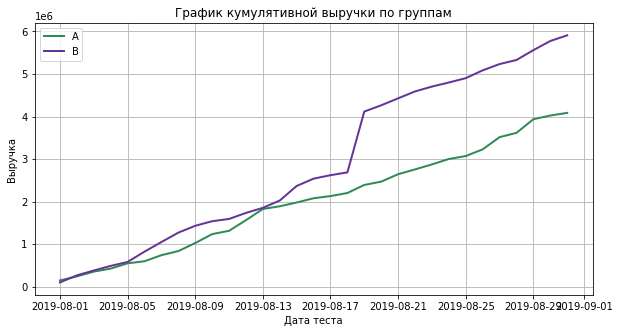

In [15]:
# построим график кумулятивной выручки для обеих групп
plt.figure(figsize=(10,5))
plt.plot(data['date'], data['revAcum'],
         label='A', color='#2E8B57', linewidth=2)
plt.plot(data['date'], data['revBcum'],
         label='B', color='#663399', linewidth=2)
plt.grid()
plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата теста')
plt.ylabel('Выручка')
plt.show()

Выручка для обеих групп практически равномерно увечличивается в течение всего теста.
Выручка группы А имеет более прямолинейный характер, в то время как для группы В наблюдается резкий скачок в выручке.  
В целом, группа В имеет более высокую выручку, нежели группа А.

Резкий скачок у группы В может сигнализировать о покупке на аномально большую сумму.


## Кумулятивный средний чек

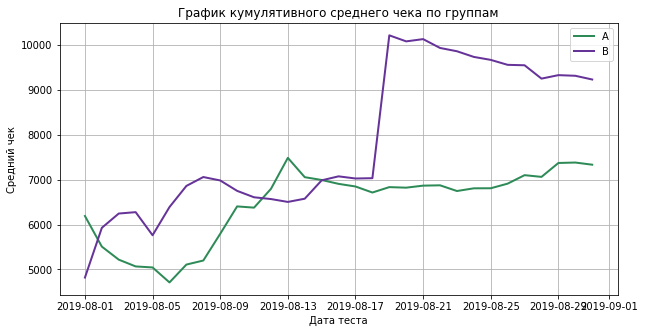

In [16]:
# построим кумулятивные график для средних чеков двух групп
plt.figure(figsize=(10,5))
plt.plot(data['date'], data['revAcum']/data['ordersAcum'],
         label='A', color='#2E8B57', linewidth=2)
plt.plot(data['date'], data['revBcum']/data['ordersBcum'],
         label='B', color='#663399', linewidth=2)
plt.grid()
plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата теста')
plt.ylabel('Средний чек')
plt.show()

Зависимости кумулятивных средних чеков, для группы В, в начале теста имеет ряд всплесков, затем, в середине теста - самое заметное увеличение среднего чека, далее наблюдается установление и тенденцией снижения.

Для группы А зависимость имеет совершенно другой характер, имеются всплески, но к концу теста значения устанавливаются.

Вероятно в группе В имеются крупные заказы, влияющие на внешний вид графика. Соответственно, после такого большого резкого увеличения среднего значения чека, группе В потребуется гораздо больше времени, для того чтобы значения установились.

## Относительное изменение кумулятивного среднего чека 

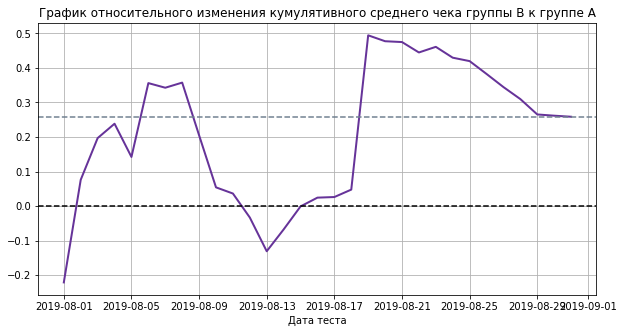

In [17]:
plt.figure(figsize=(10,5))
plt.plot(
    data['date'], 
    (data['revBcum'] / data['ordersBcum']) /
    (data['revAcum'] / data['ordersAcum']) - 1,
    color='#663399',
    linewidth=2
)
plt.grid()
plt.axhline(y=0, color='#000000', linestyle='--')
plt.axhline(y=0.259, color='#708090', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата теста')
plt.show()    

Результаты теста менялись резко несколько раз, вероятно, тогда были совершены аномальные покупки.
В целом результаты группы В лучше результатов группы А.
К концу теста группа В практически на 26% имеет средний чек выше. чем группа А

## Кумулятивная конверсия

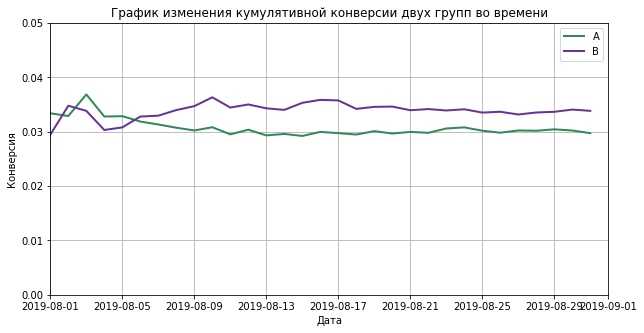

In [18]:
# построим график кумулятивной конверсии для обеих групп
plt.figure(figsize=(10,5))
plt.plot(
    data['date'], data['ordersAcum']/data['visAcum'],
    color='#2E8B57', linewidth=2, label="A")
plt.plot(
    data['date'], data['ordersBcum']/data['visBcum'],
    color='#663399', linewidth=2, label="В")
plt.grid()
plt.title('График изменения кумулятивной конверсии двух групп во времени')
plt.legend()
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019,9, 1), 0, 0.05])
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.show()

Графики имеют симметричные зависимости. Конверсия группы В оказалась выше чем конверсия группы А. На начальном этапе были флуктуации, но далее данные стабилизировались. 

## График относительного различия кумулятивных конверсий

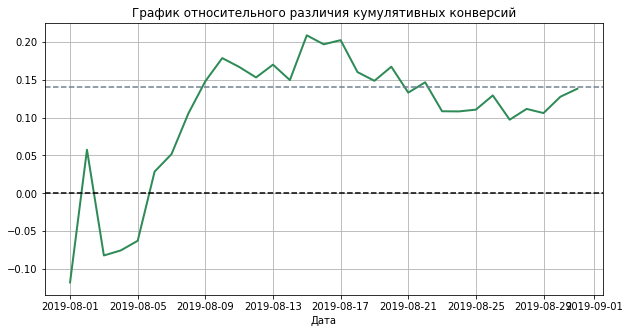

In [19]:
# построим график относительного различия кумулятивных конверсий
plt.figure(figsize=(10,5))
plt.plot(
    data['date'],
    (data['ordersBcum']/data['visBcum'])/(data['ordersAcum']/data['visAcum']) - 1,
    color='#2E8B57', linewidth=2)
plt.grid()
plt.axhline(y=0, color='#000000', linestyle='--')
plt.axhline(y=0.14, color='#708090', linestyle='--')
plt.title('График относительного различия кумулятивных конверсий')
plt.xlabel('Дата')
plt.ylabel('')
plt.show()

Исходя из графика видно, что за все время теста группа В имеет более высокие показатели конверсии. К концу теста показатели на 14% выше, чем у группы А.

## Точечный график количества заказов по пользователям

In [20]:
# сгруппируем данные для дальнейшего построения
usersorders = (orders.groupby(
    'visitorId', as_index=False)
    .agg({'transactionId' : 'nunique'})
    .rename(columns={'transactionId' : 'transaction'})
 )
usersorders.head()   

,visitorId,transaction
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


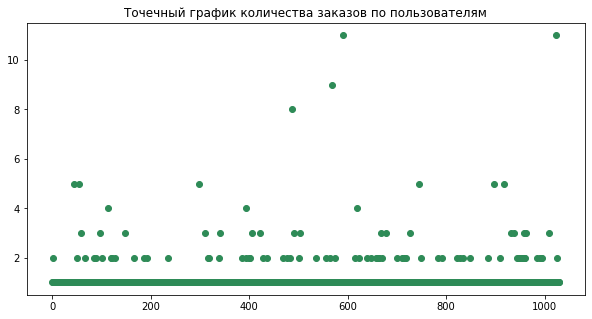

In [21]:
# зададим ось х и построим график
x_values = pd.Series(range(0, len(usersorders)))
plt.figure(figsize=(10,5))
plt.scatter(x_values, usersorders['transaction'], color='#2E8B57')
plt.title('Точечный график количества заказов по пользователям')
plt.show()

## Расчет 95-ого и 99-ого перцентилей количества заказов

In [22]:
print('95% 99%')
print(np.percentile(usersorders['transaction'], [95, 99]))

95% 99%
[2. 4.]


Исходя из анализа данных, не более 1% всех пользователей сделали 4 и более покупок, не более 5% совершило от 2х до 3х заказов. Таким образом аномальными будем считать тех, кто совершил более 2 покупок. 

## Точечный график стоимости заказов по пользователям

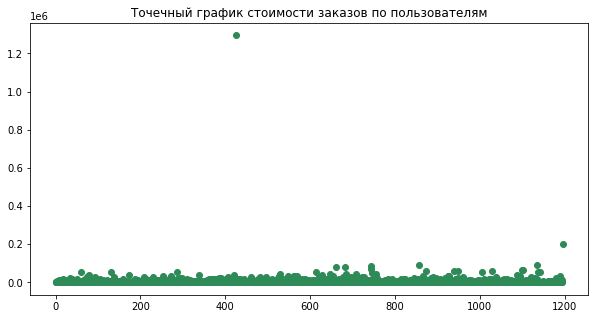

In [23]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue'], color='#2E8B57')
plt.title('Точечный график стоимости заказов по пользователям')
plt.show()

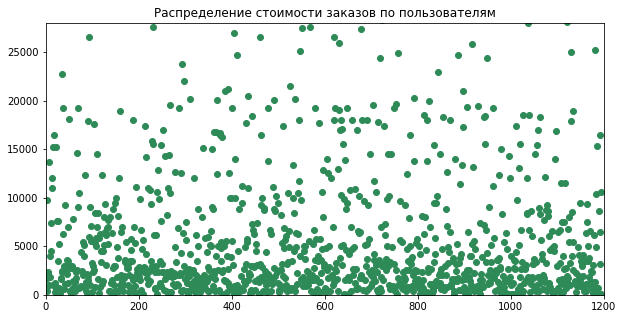

In [24]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue'], color='#2E8B57')
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('')
plt.ylabel('')
plt.axis([0, 1200, 0, 28000])  # добавила ограничение по оси с ценой заказа
plt.show()

## Расчет 95-ого и 99-ого перцентилей стоимости заказов

In [25]:
print('   95%     99%')
print(np.percentile(orders['revenue'], [95, 99]))

   95%     99%
[28000.  58233.2]


Таким образом, не более 1% пользователей совершили покупку на 58 тысяч и выше, и не более 5% - на 28000 рублей. В дальнейшем будем считать что все заказы свыше 28000 являются аномальными.

##  Cтатистическая значимость различий в конверсии между группами по «сырым» данным

In [26]:
# соберем заказы по пользователям в зависимости от группы
ordersA = (orders.query('group == "A"')
            .groupby('visitorId', as_index=False)
            .agg({'transactionId' : 'nunique'})
            .rename(columns={'transactionId' : 'transA'})
          )
ordersB = (orders.query('group == "B"')
            .groupby('visitorId', as_index=False)
            .agg({'transactionId' : 'nunique'})
            .rename(columns={'transactionId' : 'transB'})
          )

In [27]:
# в данных переменных пользователям каждой группы присвоено количество заказов
# тем, кто ничего не заказал, присвоен 0
sampleA = pd.concat(
    [
        ordersA['transA'],
        pd.Series(
            0,
            index=np.arange(
                data['visAday'].sum() - len(ordersA['transA'])
            ), name='orders'
        ),
    ], axis=0
)

sampleB = pd.concat(
    [
        ordersB['transB'],
        pd.Series(
            0,
            index=np.arange(
                data['visBday'].sum() - len(ordersB['transB'])
            ), name='orders'
        ),
    ], axis=0
)

**Сформулируем гипотезы**\
Нулевая гипотеза: различий конверсий между группами нет\
Альтернативная гипотеза: различия в конверсии между группами есть

In [28]:
mann_test = '{0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1])
difB = '{0:.3f}'.format(sampleB.mean()/sampleA.mean() - 1)
#print(type(mann_test))
if float(mann_test) > 0.05:
    print(f'p_value = {mann_test} нулевую гипотезу не отвергаем')
else:
    print(f'p_value = {mann_test} нулевую гипотезу отвергаем')
print(f'Группа В в среднем лучше группы А на {float(difB)*100}%')

p_value = 0.017 нулевую гипотезу отвергаем
Группа В в среднем лучше группы А на 13.8%


Исходя из данных получается что конверсии двух групп различаются. Это может поризойти вследствии того что ряд покупателей совершали множество покупок, или покупали на большую сумму.

##  Cтатистическая значимость различий в конверсии между средними чеками по «сырым» данным

**Сформулируем гипотезы**\
Нулевая гипотеза: различий между средними чеками в группах нет\
Альтернативная гипотеза: различия между средними чеками в группах есть

In [29]:
mann_test = '{0:.3f}'.format(
    stats.mannwhitneyu(
        orders.query('group == "A"')['revenue'],
        orders.query('group == "B"')['revenue'])[1]
    )

difB = '{0:.3f}'.format(
    orders.query('group == "B"')['revenue'].mean()/
    orders.query('group == "A"')['revenue'].mean() - 1
)

if float(mann_test) > 0.05:
    print(f'p_value = {mann_test} нулевую гипотезу не отвергаем')
else:
    print(f'p_value = {mann_test} нулевую гипотезу отвергаем')
print(f'Средний чек группы В больше чека группы А на {round(float(difB)*100, 2)}%')

p_value = 0.729 нулевую гипотезу не отвергаем
Средний чек группы В больше чека группы А на 25.9%


Средний чек группы В больше среднего чека группы А на 26%, очевидно, в группе В имеются пользователи, совершившие дорогие покупки. В дальнейшем мы очистим данные от аномально высоких, и проверим еще раз.

## Cтатистическая значимость различий в конверсии между группами по «очищенным» данным

In [30]:
# собираем пользователей совершивших аномально большое количество покупок
# и покупки на аномально большую сумму
#print(np.percentile(orders['revenue'], [95, 99]))
revenue_proc = np.percentile(orders['revenue'], [95])
trans_proc = np.percentile(usersorders['transaction'], [95])
abnormalusers = (
    pd.concat([
        usersorders.query('transaction > @trans_proc[0]')['visitorId'],
        orders.query('revenue > @revenue_proc[0]')['visitorId']
    ], 
    axis=0
    ).drop_duplicates()  
    .sort_values()
)

In [31]:
# отфильтруем данные
sampleAfilt = pd.concat(
    [
        ordersA
        [np.logical_not(ordersA['visitorId'].isin(abnormalusers))]['transA'],
        pd.Series(
            0,
            index=np.arange(
                data['visAday'].sum() - len(ordersA['transA'])
            ), name='orders'
        ),
    ], axis=0
)

sampleBfilt = pd.concat(
    [
        ordersB
        [np.logical_not(ordersB['visitorId'].isin(abnormalusers))]['transB'],
        pd.Series(
            0,
            index=np.arange(
                data['visBday'].sum() - len(ordersB['transB'])
            ), name='orders'
        ),
    ], axis=0
)

In [32]:
mann_test = '{0:.3f}'.format(stats.mannwhitneyu(sampleAfilt, sampleBfilt)[1])
difB = '{0:.3f}'.format(sampleBfilt.mean()/sampleAfilt.mean() - 1)
#print(type(mann_test))
if float(mann_test) > 0.05:
    print(f'p_value = {mann_test} > 0.05: конверсии одинаковы')
else:
    print(f'p_value = {mann_test} < 0.05: конверсии различны')
print(f'Конверсия группы В на {round(float(difB)*100, 2)}% выше группы А')

p_value = 0.012 < 0.05: конверсии различны
Конверсия группы В на 17.6% выше группы А


После того как мы отфильтровали данные мы заново посчитали статистическую значимость различий в конверсии между группами теста. Результаты конверсии практически не изменились, при этом разница в конверсиях двух групп слегка увеличилась (до 18%).

Полученное значение p-value говорит о том, что конверсия двух групп различна, получить такое или большее различие случайно можно с вероятностью чуть выше 1%, что ниже статистически значимой величины. На этом основании мы отвергаем нулевую гипотезу.

##  Cтатистическая значимость различий в конверсии между средними чеками по «очищенным» данным

In [33]:
mann_test = '{0:.3f}'.format(
    stats.mannwhitneyu(
        orders.query('group == "A" & (not visitorId in @abnormalusers)')['revenue'], 
        orders.query('group == "B" & (not visitorId in @abnormalusers)')['revenue'])[1]
        )
difB = '{0:.3f}'.format(
    orders.query('group == "B" & (not visitorId in @abnormalusers)')['revenue'].mean()
    /orders.query('group == "A" & (not visitorId in @abnormalusers)')['revenue'].mean()
    - 1
    )
print(mann_test)
print(difB)

0.753
-0.022


После того как данные были очищенны от аномальных значений, была заново расчитана статистическая значимость различий средних чеков двух групп.

Значение p_value говорит о том, что с вероятностью около 75% есть вероятность получить такое или большее различие случайно. Это слишком большая вероятность чтобы говорить о значимом различии средних чеков двух групп.

При этом разница чеков с 20% снизилась до 2%.

## Решение по результатам теста

Исходя из результатов теста:
* Имеются статистически значимые различия между конверсиями двух групп, как для "сырых", так и для "очищенных" данных.
* Нет статистически значимых различий между средними чеками двух групп, как для "сырых", так и для "очищенных" данных.
* К концу теста конверсия группы В примерно на 14% выше конверсии группы А, и продолжает увеличиваться

Таким образом можно остановить тест, и объявить что группа В лучше группы А.